Dataset:
https://drive.google.com/drive/folders/1CBu4hgOJEVuONYfzN7EwU0bNPJpOblVZ?usp=sharing

In [1]:
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Creating a Training Dataset**

In [3]:
batch_size = 32
img_height = 180
img_width = 180


train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/gdrive/MyDrive/Automating_Port_Operations_dataset',
  validation_split=0.2,
  subset="training",
  seed=43,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1162 files belonging to 9 classes.
Using 930 files for training.


**Creating a Validation Dataset**

In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/gdrive/MyDrive/Automating_Port_Operations_dataset',
  validation_split=0.2,
  subset="validation",
  seed=43,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1162 files belonging to 9 classes.
Using 232 files for validation.


**Visualizing a Subset of Images from the Training Dataset**

['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat']


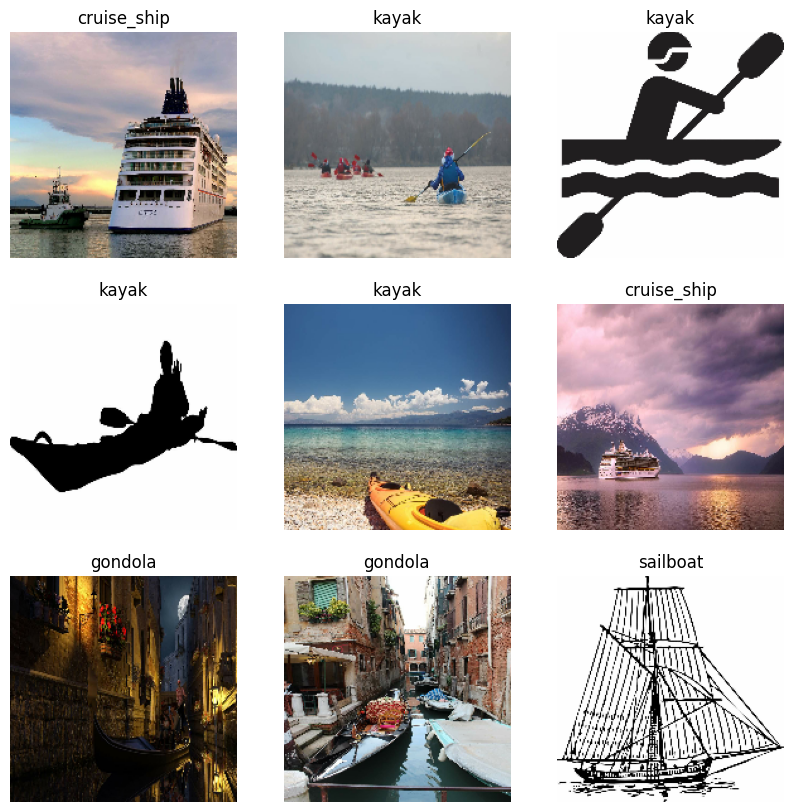

In [5]:
class_names = train_ds.class_names
print(class_names)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Preprocessing and Normalizing the Training Dataset**

In [6]:
AUTOTUNE = tf.data.AUTOTUNE #Way to structure the dataset.

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
from tensorflow.keras import layers
import numpy as np

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


0.0 1.0


**Creating a Convolutional Neural Network Model With Data Augmentation**
1.	Build a CNN network to classify the boat.

In [8]:
from tensorflow import keras
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [9]:
from keras import models, layers

model = models.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),

  layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
  layers.MaxPool2D(),
  layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
  layers.MaxPool2D(),
  layers.GlobalAveragePooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names), activation='softmax')
])

**Summarizing and Compiling the Model**

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [10]:
from keras import optimizers

model.compile(optimizer='adam',
              #Becauce it's classification we use CategoricalCrossentropy, and we use Sparse because we have 5 classes.
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Training the Model**

In [ ]:
model.fit(
          train_ds,
          validation_data=val_ds,
          epochs = 20,
          )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 [==============================] - 101s 3s/step - loss: 1.9305 - accuracy: 0.3333 - val_loss: 1.8116 - val_accuracy: 0.3017
Epoch 2/20
30/30 [==============================] - 42s 1s/step - loss: 1.8142 - accuracy: 0.3430 - val_loss: 1.7992 - val_accuracy: 0.3017
Epoch 3/20
30/30 [==============================] - 42s 1s/step - loss: 1.8070 - accuracy: 0.3430 - val_loss: 1.7913 - val_accuracy: 0.3017
Epoch 4/20
30/30 [==============================] - 51s 2s/step - loss: 1.8079 - accuracy: 0.3430 - val_loss: 1.8000 - val_accuracy: 0.3017
Epoch 5/20
30/30 [==============================] - 45s 2s/step - loss: 1.8105 - accuracy: 0.3430 - val_loss: 1.7898 - val_accuracy: 0.3017
Epoch 6/20
30/30 [==============================] - 46s 2s/step - loss: 1.7929 - accuracy: 0.3430 - val_loss: 1.7722 - val_accuracy: 0.3017
Epoch 7/20
30/30 [==============================] - 42s 1s/step - loss: 1.7725 - accuracy: 0.3430 - val_loss: 1.7625 - val_accuracy: 0.3017
Epoch 8/20
30/30 [============

**Evaluate the model on test images**

In [ ]:
model.evaluate(val_ds)

8/8 [==============================] - 2s 272ms/step - loss: 1.6656 - accuracy: 0.3448


[1.6655646562576294, 0.3448275923728943]

**2.	Build a lightweight model with the aim of deploying the solution on a mobile device using transfer learning. You can use any lightweight pre-trained model as the initial (first) layer. MobileNetV2 is a popular lightweight pre-trained model built using Keras API. **

In [31]:

model = models.Sequential([

  keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', input_shape=(180, 180, 3)),
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.2),
  layers.Dense(265, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.Dense(len(class_names), activation='softmax')
])


In [32]:
model.compile(optimizer='adam',
              #Becauce it's classification we use CategoricalCrossentropy, and we use Sparse because we have 5 classes.
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
lite=model.fit(
          train_ds,
          validation_data=val_ds,
          epochs = 50,
          )

Epoch 1/50
30/30 [==============================] - 142s 5s/step - loss: 3.9664e-04 - accuracy: 1.0000 - val_loss: 1.7700 - val_accuracy: 0.7284
Epoch 2/50
30/30 [==============================] - 128s 4s/step - loss: 3.8628e-04 - accuracy: 1.0000 - val_loss: 1.6896 - val_accuracy: 0.7371
Epoch 3/50
30/30 [==============================] - 131s 4s/step - loss: 4.4361e-04 - accuracy: 1.0000 - val_loss: 1.6381 - val_accuracy: 0.7457
Epoch 4/50
30/30 [==============================] - 122s 4s/step - loss: 3.9917e-04 - accuracy: 1.0000 - val_loss: 1.5931 - val_accuracy: 0.7543
Epoch 5/50
30/30 [==============================] - 119s 4s/step - loss: 3.5790e-04 - accuracy: 1.0000 - val_loss: 1.5551 - val_accuracy: 0.7457
Epoch 6/50
30/30 [==============================] - 117s 4s/step - loss: 3.2949e-04 - accuracy: 1.0000 - val_loss: 1.5142 - val_accuracy: 0.7500
Epoch 7/50
30/30 [==============================] - 125s 4s/step - loss: 3.2240e-04 - accuracy: 1.0000 - val_loss: 1.4866 - val_ac

In [34]:
model.evaluate(val_ds)

8/8 [==============================] - 8s 873ms/step - loss: 1.8331 - accuracy: 0.7112


[1.833054780960083, 0.7112069129943848]

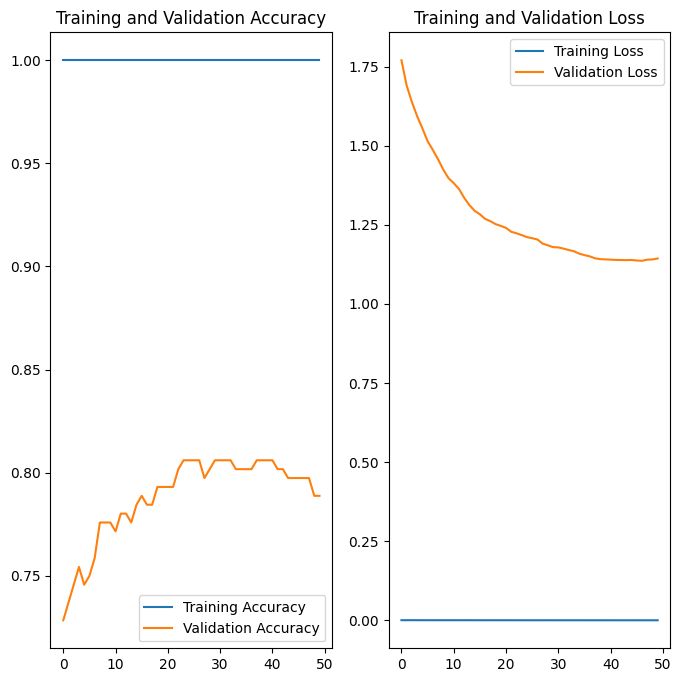

In [44]:
acc = lite.history['accuracy']
val_acc = lite.history['val_accuracy']

loss = lite.history['loss']
val_loss = lite.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations:**

- The lightweight model correctly predicts a higher percentage of the outcomes than the first model.
-  The lightweight model has also fewer errors in its predictions than the first model.